<a href="https://colab.research.google.com/github/Antu0/Computational-Geoscience/blob/main/CG_Varigram_Kriging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import seaborn as sns

Upper half (including diagonal) as vector: [  1.60482554  82.83732273 116.54243842 ...  72.01991561 169.18769947
  97.16952657]
Upper half (including diagonal) as vector: [0.045602  1.609218  0.0772245 ... 0.63845   2.337122  0.532512 ]
Midpoints: 34
Semi-variance: 34


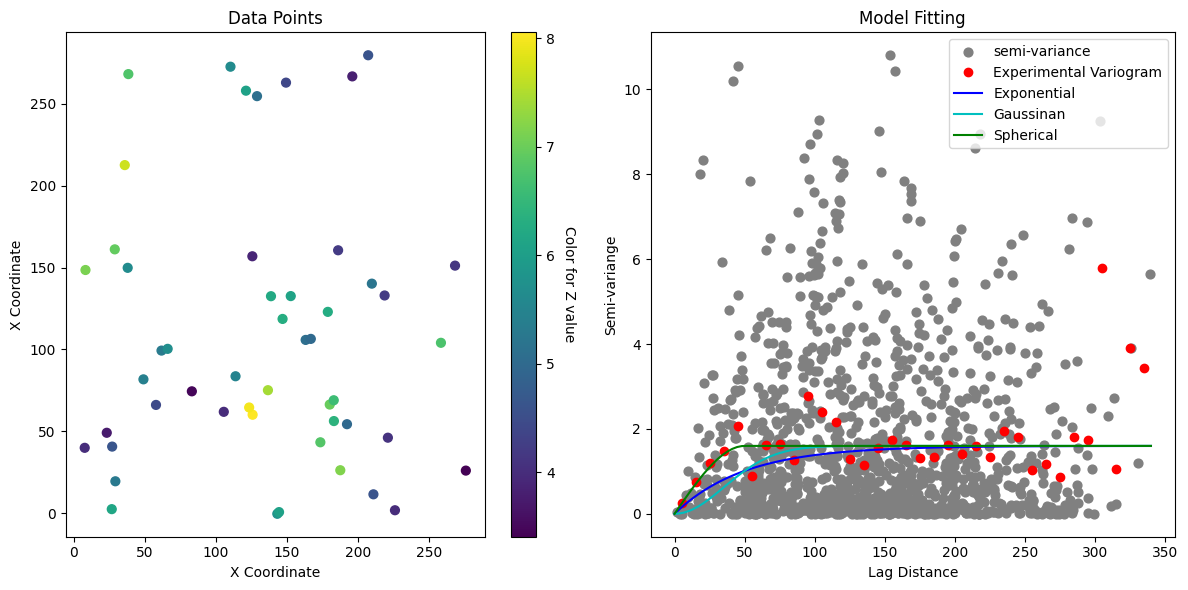

In [15]:
# Import/read your data
data=np.loadtxt('/content/drive/MyDrive/Antu /504/SampleData.dat')
#data = pd.read_csv('SampleData.csv')
x=data[:, 0]
y=data[:, 1]
z=data[:, 2]

#Calculate Pairwise Distances
coords = data = pd.DataFrame({'x': x, 'y': y})


dist_matrix = cdist(coords, coords, metric='euclidean')  # Euclidean distance matrix
z_matrix = np.outer(z, np.ones_like(z))  # Outer product to create matrix for comparison
squared_diff_matrix = 0.5*((z_matrix - z_matrix.T) ** 2)  # Compute the squared differences for all pairs

#Extract the upper triangular part (including the diagonal)
dist_upper_half = np.triu(dist_matrix)
z_upper_half = np.triu(squared_diff_matrix)

# Convert the upper half into a vector (flatten and exclude zero entries if necessary)
# Use np.triu(matrix, k=0) to include the diagonal (k=0) or k=1 to exclude diagonal elements
dist_vector = dist_upper_half[np.triu_indices_from(dist_upper_half, k=1)]
z_vector = z_upper_half[np.triu_indices_from(z_upper_half, k=1)]

print("Upper half (including diagonal) as vector:", dist_vector)
print("Upper half (including diagonal) as vector:", z_vector)

bins = np.arange(0, np.max(dist_vector) + 10, 10)  # Distance bins (e.g., 0-10m, 10-20m, etc.)
semi_variance = []
bin_counts = []
midpoints = (bins[:-1] + bins[1:]) / 2  # Midpoints of bins

# Loop through each bin and compute the semi-variance
for i in range(len(bins) - 1):
    in_bin = np.where((dist_vector >= bins[i]) & (dist_vector < bins[i + 1]))  # Find pairs in this bin
    if len(in_bin[0]) > 0:  # If there are pairs in this bin
        semi_variance.append(np.mean(z_vector[in_bin]))
        bin_counts.append(len(in_bin[0]))
    else:  # For empty bins, append placeholder (e.g., None or 0)
        semi_variance.append(None)
        bin_counts.append(0)

# Ensure lengths match
print(f"Midpoints: {len(midpoints)}")
print(f"Semi-variance: {len(semi_variance)}")

# Define the Model Functions (Exponential, Gaussian, Spherical)
nugget=0.0
sill=1.6
hrange=50

def exp_model(h, nugget, sill, range_):
    return nugget + (sill - nugget) * (1 - np.exp(-h / range_))

def gaussian_model(h, nugget, sill, range_):
     return nugget + sill * (1 - np.exp(-(h / range_)**2))

def spherical_model(h, nugget, sill, range_):
     return np.where(h <= range_, nugget + sill * (1.5 * (h / range_) - 0.5 * (h / range_)**3), nugget + sill)

# Fit the Models using Non-Linear Least Squares
# Initial guesses for parameters
#initial_params = [0.1, np.max(semi_variance), 2000]
h_values = np.linspace(0, np.max(bins), 100)

exp_variogram =exp_model(h_values,nugget,sill,hrange)
gaus_variogram =gaussian_model(h_values,nugget,sill,hrange)
sph_variogram =spherical_model(h_values,nugget,sill,hrange)
#%
fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns
scatter1=axs[0].scatter(x, y, c=z, cmap='viridis', s=40)
axs[0].set_title('Data Points')
axs[0].set_xlabel('X Coordinate')
axs[0].set_ylabel('X Coordinate')
cbar1 = plt.colorbar(scatter1, ax=axs[0])
cbar1.set_label('Color for Z value', rotation=270, labelpad=15)
# Adjust layout for better spacing
# Adjust layout for better spacing
axs[1].scatter(dist_vector,z_vector, c='grey', s=40,label='semi-variance')
axs[1].plot(midpoints, semi_variance, 'ro',label='Experimental Variogram')
axs[1].legend()
axs[1].plot(h_values, exp_variogram, 'b-',label='Exponential')
axs[1].plot(h_values, gaus_variogram, 'c-',label='Gaussinan')
axs[1].plot(h_values, sph_variogram, 'g-',label='Spherical')
axs[1].legend()
axs[1].set_title('Model Fitting')
axs[1].set_xlabel('Lag Distance')
axs[1].set_ylabel('Semi-variange')
plt.tight_layout()
# Show the plot
plt.show()

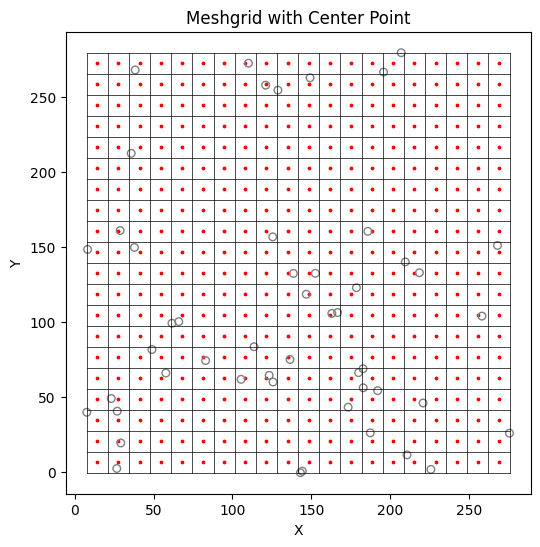

In [16]:

#load data
data=np.loadtxt('/content/drive/MyDrive/Antu /504/SampleData.dat')
#data = pd.read_csv('SampleData.csv')
x_known =data[:, 0]
y_known =data[:, 1]
z_known=data[:, 2]

#%% Define the grid where you want to calculate kriged values
ngrid=20
x = np.linspace(min(x_known), max(x_known), ngrid+1)
y = np.linspace(min(y_known), max(y_known), ngrid+1)  # Use y_known for grid_y
grid_x, grid_y = np.meshgrid(x, y)

# Plot the vertical and horizontal mesh lines
plt.figure(figsize=(6,6))
for i in range(len(x)):
    plt.plot([x[i]]*len(y), y, 'k-', lw=0.5)  # Vertical lines
for j in range(len(y)):
    plt.plot(x, [y[j]]*len(x), 'k-', lw=0.5)  # Horizontal lines

# Find and mark the center of the grid
# Compute cell centers
cell_x = (x[:-1] + x[1:]) / 2  # Midpoints along x
cell_y = (y[:-1] + y[1:]) / 2  # Midpoints along y
Cx, Cy = np.meshgrid(cell_x, cell_y)  # Create meshgrid of cell centers
plt.scatter(Cx, Cy, color='red', s=3)
plt.scatter(x_known, y_known, edgecolors='grey', facecolors='none', s=30)
# Labels and display
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Meshgrid with Center Point')
plt.show()


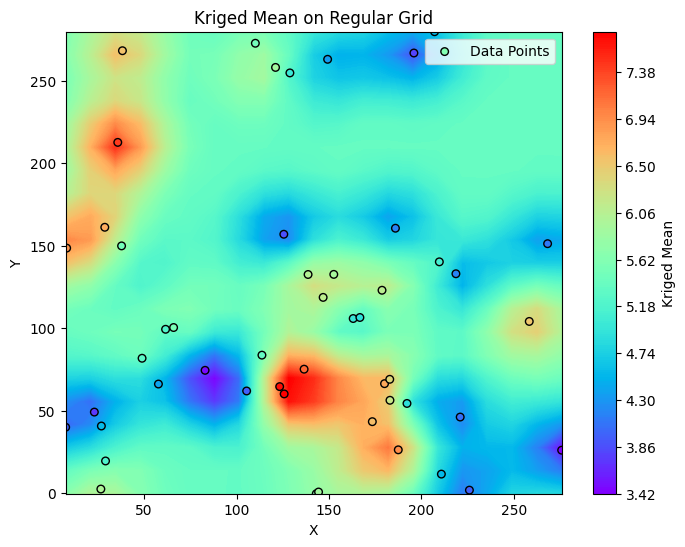

In [17]:
# Variogram model (example: spherical model)
def variogram(h):
    nugget = 0.0
    sill = 1.6
    hrange = 50
    return np.where(h <= hrange, nugget + sill * (1.5 * (h / hrange) - 0.5 * (h / hrange)**3), nugget + sill)

# Create arrays for kriged values and variance
z_kriged = np.zeros_like(grid_x)
kriging_variance = np.zeros_like(grid_x)

# Solve kriging system for each grid point
for i in range(grid_x.shape[0]):
    for j in range(grid_x.shape[1]):
        # Current grid point
        x, y = grid_x[i, j], grid_y[i, j]

        # Compute distances from the current grid point to known points
        distances = np.sqrt((x_known - x)**2 + (y_known - y)**2)

        # Compute the variogram values for the grid point to known points
        gamma_k = np.array([variogram(h) for h in distances])

        # Compute the variogram matrix for known points
        n = len(x_known)
        gamma_matrix = np.zeros((n + 1, n + 1))
        for k in range(n):
            for l in range(n):
                gamma_matrix[k, l] = variogram(
                    np.sqrt((x_known[k] - x_known[l])**2 + (y_known[k] - y_known[l])**2)
                )
        gamma_matrix[-1, :-1] = 1  # Add Lagrange multiplier row
        gamma_matrix[:-1, -1] = 1  # Add Lagrange multiplier column
        gamma_matrix[-1, -1] = 0   # Bottom-right corner of matrix

        # Add Lagrange multiplier to gamma_k
        gamma_k = np.append(gamma_k, 1)

        # Solve the kriging system
        weights = np.linalg.solve(gamma_matrix, gamma_k)

        # Compute the kriged estimate
        z_kriged[i, j] = np.dot(weights[:-1], z_known)

        # Compute the kriging variance
        kriging_variance[i, j] = np.dot(weights[:-1], gamma_k[:-1]) - np.dot(weights[:-1], np.dot(gamma_matrix[:-1, :-1], weights[:-1]))

# Plotting results
plt.figure(figsize=(8, 6))
levels = 256
plt.contourf(grid_x, grid_y, z_kriged, levels=levels, cmap="rainbow")
plt.colorbar(label="Kriged Mean")
plt.scatter(x_known, y_known, c=z_known, edgecolors='black', cmap='rainbow', s=30, label="Data Points")
plt.legend()
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Kriged Mean on Regular Grid")
plt.xlim(min(x_known), max(x_known))
plt.ylim(min(y_known), max(y_known))
plt.show()

/tmp/ipython-input-3814217915.py:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x_known, y_known, facecolors='none', edgecolors='black', cmap='rainbow', s=30, label="Data Points")


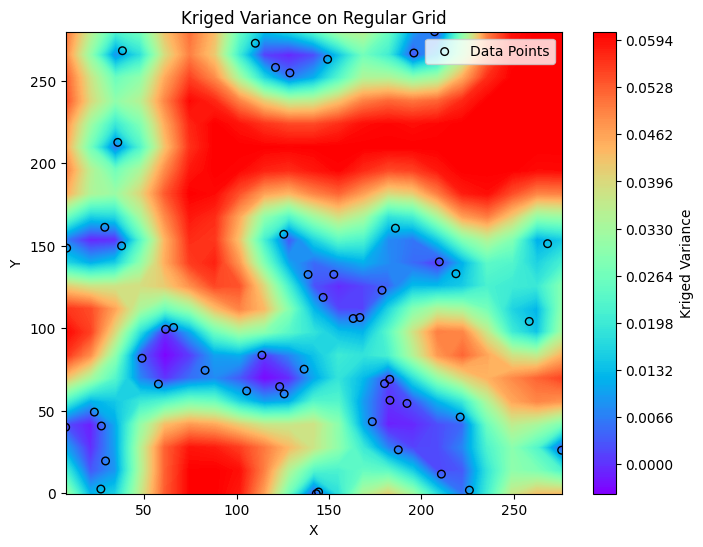

In [18]:
plt.figure(figsize=(8, 6))
plt.contourf(grid_x, grid_y, kriging_variance, levels=levels, cmap="rainbow")
plt.colorbar(label="Kriged Variance")
plt.scatter(x_known, y_known, facecolors='none', edgecolors='black', cmap='rainbow', s=30, label="Data Points")
plt.legend()
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Kriged Variance on Regular Grid")
plt.xlim(min(x_known), max(x_known))
plt.ylim(min(y_known), max(y_known))
plt.show()